# Highland Food Hygiene Data Analysis

## Setup

Import the SQLite database for analysis. The database contains business names, post codes, coordinates and hygiene rating. To update the database, use the `data/fetch_data.py` file to update the database from the XML source on the food ratings website: https://ratings.food.gov.uk/open-data

In this case we will be using Highland data for local business insights. The food hygiene ratings have the following scheme in Scotland:

- **Pass**:  means they meet the legal requirements for food hygiene.
- **Improvement Requried**: means the business didn’t meet the legal requirements and needs to make improvements.
- **Exempt Premises** means the business has been inspected by a local authority food safety officer, met the pass criteria, but don’t meet the criteria to be part of the scheme.  These businesses are low-risk to people’s health in terms of food safety and you perhaps wouldn’t normally think of them as a food business – for example, newsagents, chemist shops or visitor centres selling tins of biscuits.
- **Awaiting Inspection**: means a new business or new business owner is waiting for an inspection.


Further information can be found at this link: https://www.foodstandards.gov.scot/consumers/food-safety/buying-food-eating-out/food-hygiene-information-scheme/about-the-food-hygiene-information-scheme

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from os import getcwd
import folium
from folium.plugins import HeatMap


# Configure plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 9)

# Connect to the SQLite database
#Run fetch_data.py in the data directory to update the database from the FHIS website
home_path = getcwd()
print(home_path)
conn = sqlite3.connect("/mnt/d/renfrewshire_business_insights/data/highland_hygiene.db") #adjust path accordingly

/mnt/d/renfrewshire_business_insights/reports


## Overview of Data

Have a quick look at the data to understand the column types and structure.

In [2]:
#Initial scoping of the SQL database to confirm all is working well
df = pd.read_sql_query("SELECT * FROM establishments;", conn)
#print(df.head(10))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5567 entries, 0 to 5566
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   FHRSID                      5567 non-null   object
 1   LocalAuthorityBusinessID    5567 non-null   object
 2   BusinessName                5567 non-null   object
 3   BusinessType                5567 non-null   object
 4   BusinessTypeID              5567 non-null   object
 5   AddressLine2                4495 non-null   object
 6   AddressLine3                5329 non-null   object
 7   AddressLine4                4376 non-null   object
 8   PostCode                    5474 non-null   object
 9   RatingValue                 5567 non-null   object
 10  RatingKey                   5567 non-null   object
 11  RatingDate                  3436 non-null   object
 12  LocalAuthorityCode          5567 non-null   object
 13  LocalAuthorityName          5567 non-null   obje

## Top 10 Business Types by Count

Look at the top 10 business categories by number registered in the Highlands area. We can generate a bar plot with the count of businesses and a pie chart to show their distribution.

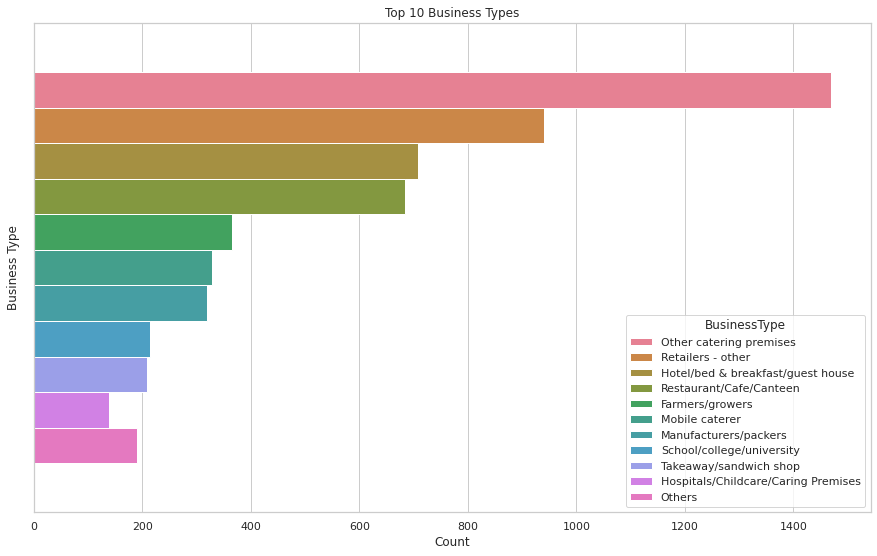

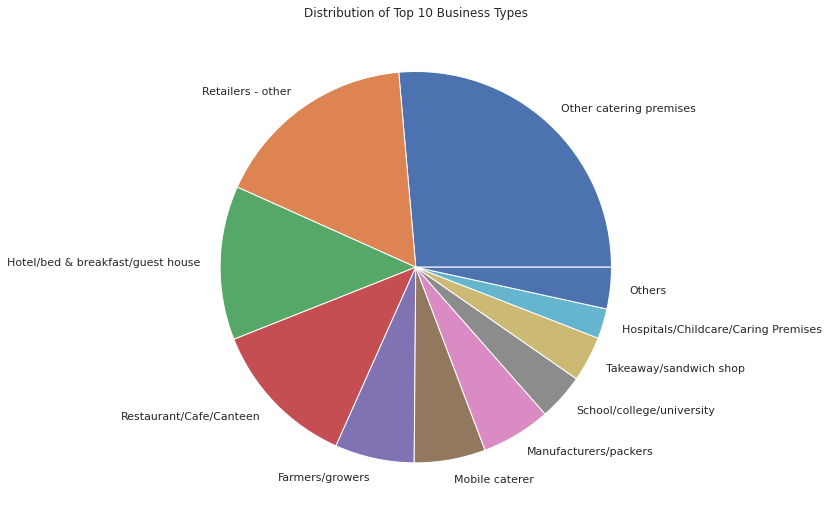

In [9]:
#Use SQL to read the database and write to a Pandas DataFrame
business_counts = pd.read_sql_query("""
SELECT BusinessType, COUNT(*) as Count
FROM establishments
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Manipulate the dataframe to produce an others category for below top 10
def topN(df, N, column):
    """A function that takes an ordered, counted, categorised dataframe and sums all categories
    for chosen column over >N to Others
    
    df - Pandas dataframe
    N - integer, top N categories
    column - str, column in df over which to sum other categories"""
    
    df2 = df[:N].copy()
    new_row = pd.DataFrame(data = {
    column : ['Others'],
    'Count' : [df['Count'][N:].sum()]
    })
    
    df = pd.concat([df2,new_row])
    return df

#the top 10
business_counts = topN(business_counts, 10, "BusinessType")

#Plotting
#print(business_counts)
sns.barplot(data=business_counts, x="Count", hue="BusinessType", legend = True)
plt.title("Top 10 Business Types")
plt.xlabel("Count")
plt.ylabel("Business Type")
plt.show()

#Pie chart
# define Seaborn color palette to use
business_counts.plot.pie(y = "Count", labels = business_counts["BusinessType"], legend = False)
plt.title("Distribution of Top 10 Business Types")
#plt.xlabel("Rating")
plt.ylabel("") #leave the ylabel empty
#plt.ylabel("Number of Establishments")
plt.show()



[Insert analysis here]

## Hygiene Score Distribution

We can group the businesses by hygiene rating score to get an idea of the proportion who have passed, who needs improvement and other circumstances.

            RatingValue  Count
0                  Pass   2491
1   Awaiting Inspection   2443
2  Improvement Required    430
3                Exempt    181
4     Pass and Eat Safe     22
Total counts is:  5567


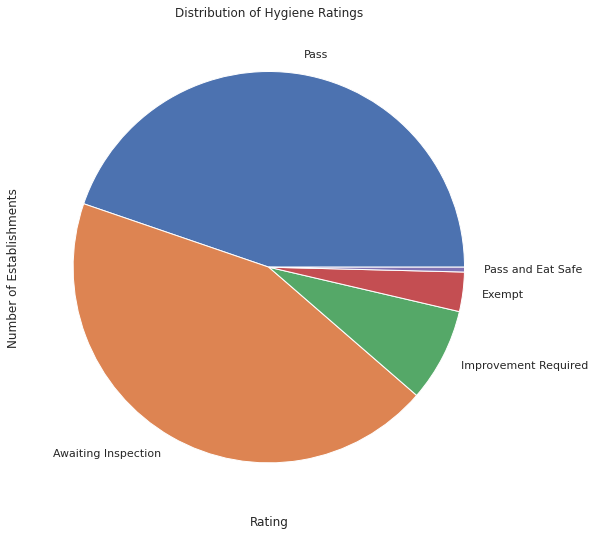

In [4]:
# Get rating value counts
rating_counts = pd.read_sql_query("""
SELECT RatingValue, COUNT(*) as Count
FROM establishments
GROUP BY RatingValue
ORDER BY Count DESC
""", conn)

# Plot
print(rating_counts) # print the data frame
total = rating_counts["Count"].sum()
print("Total counts is: ", total)

rating_counts.plot.pie(y = "Count", labels = rating_counts["RatingValue"], legend = False)
plt.title("Distribution of Hygiene Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Establishments")
plt.show()

## Deep dive into hygiene ratings

We can breakdown the individual ratings to find any correlations between business type and hygiene rating.

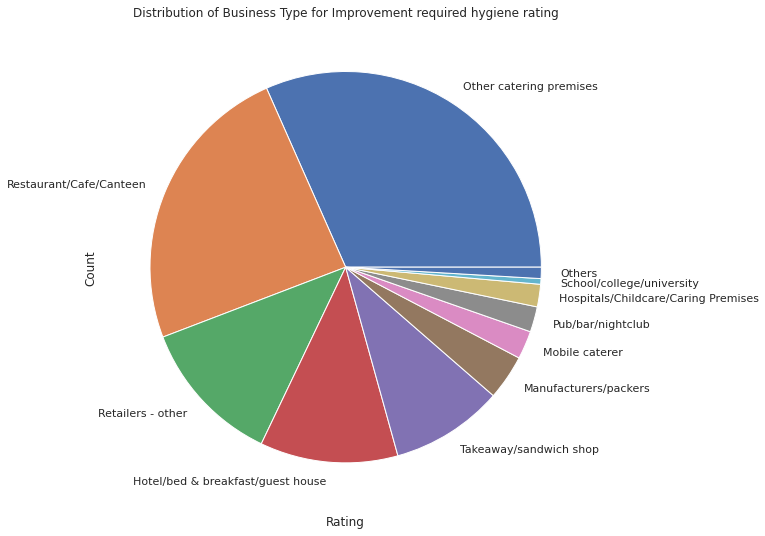

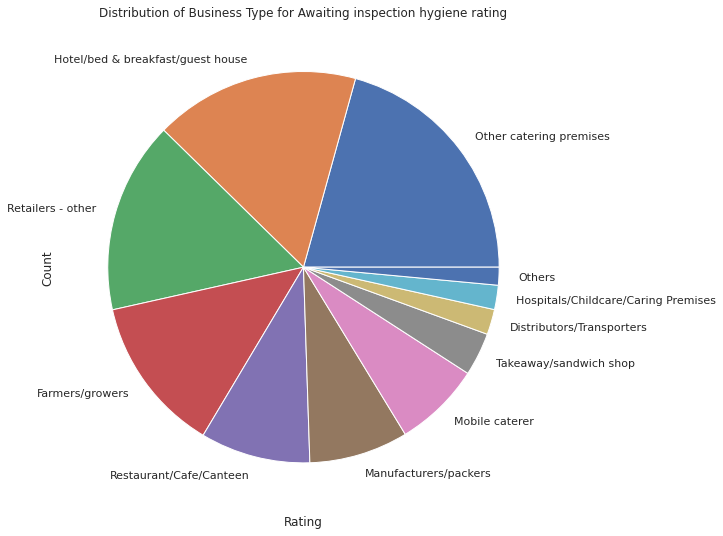

In [11]:
#Get the improvement required ratings along with various parameters
improvement_required = pd.read_sql_query("""
SELECT RatingValue, BusinessType, COUNT(*) as Count
FROM establishments
WHERE RatingValue = 'Improvement Required'
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Print
#print(improvement_required) # print the data frame

#Plotting
improvement_required = topN(improvement_required, 10, "BusinessType") #convertunder top 10 to others
improvement_required.plot.pie(y = "Count", labels = improvement_required["BusinessType"], legend = False)
plt.title("Distribution of Business Type for Improvement required hygiene rating")
plt.xlabel("Rating")
#plt.ylabel("Number of Establishments")
plt.show()

#Get the Exempt ratings along with various parameters
waiting_df = pd.read_sql_query("""
SELECT RatingValue, BusinessType, COUNT(*) as Count
FROM establishments
WHERE RatingValue = 'Awaiting Inspection'
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Print
#print(exempt) # print the data frame

#Plotting
waiting_df = topN(waiting_df, 10, "BusinessType")
waiting_df.plot.pie(y = "Count", labels = waiting_df["BusinessType"], legend = False)
plt.title("Distribution of Business Type for Awaiting inspection hygiene rating")
plt.xlabel("Rating")
#plt.ylabel("Number of Establishments")
plt.show()

#Calculations using the global data frame
#takeaway = df[df["BusinessType"] == "Takeaway/sandwich shop"]
#takeaway.head(10)


Exempt status is granted for businesses that don't produce their own food but do sell pre-packaged products and medicines which is corroborated here: https://essentialfoodhygiene.co.uk/what-are-the-three-food-hygiene-ratings-for-scotland/.

## Businesses by Post Code

Using the intial part of a UK postcode, an indication of geographical area can be found. Lets find how many business fit in these areas.

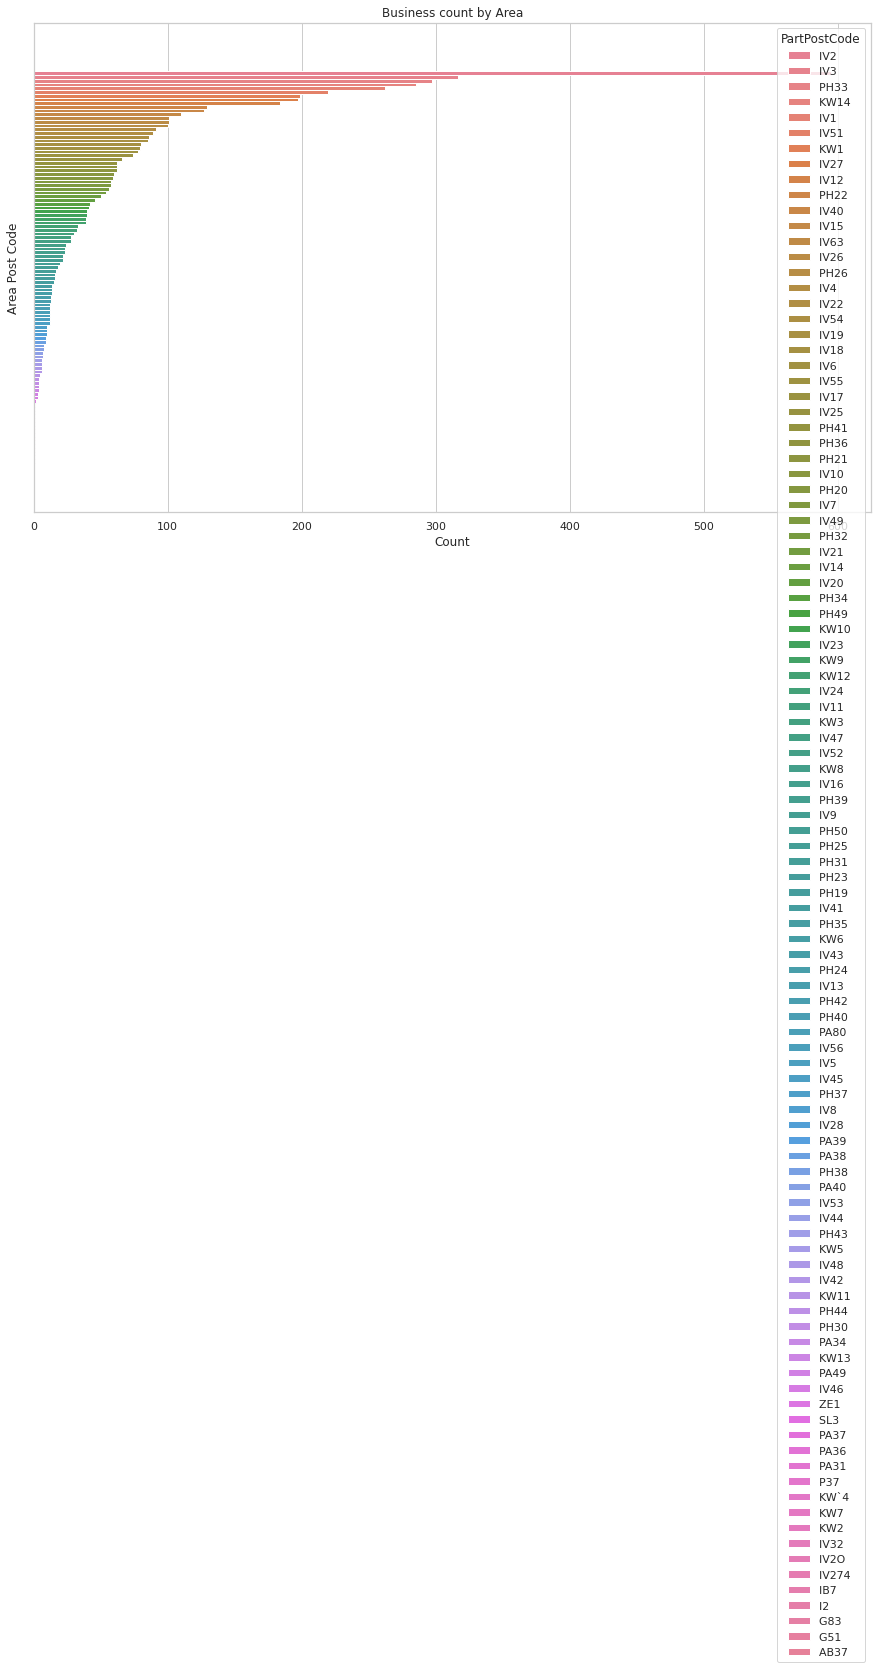

In [12]:
business_by_area = pd.read_sql_query("""
SELECT COUNT(*) as "Number of businesses", SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode
FROM establishments
GROUP BY PartPostCode
ORDER BY "Number of businesses" DESC
LIMIT 20;
""", conn)

#print(business_by_area)
sns.barplot(data=business_by_area, x="Number of businesses", hue="PartPostCode", legend = True)
plt.title("Business count by Area")
plt.xlabel("Count")
plt.ylabel("Area Post Code")
plt.show()



## Map business location data using Geopandas

Using a shapefile for the local authority boundaries from the Improvement Service (license below), the business location data can be placed on a map.

"The dataset is provided under Open Government Licence (OGL) for download and use. You are free to copy, publish, distribute and transmit the information as long as you acknowledge the source as coming from Improvement Service under OGL."

['local_auth', 'code', 'hectares', 'geometry']
All available authority names: 
['Angus' 'Clackmannanshire' 'Dundee City' 'East Ayrshire'
 'East Dunbartonshire' 'East Renfrewshire' 'Falkirk' 'Glasgow City'
 'Inverclyde' 'Midlothian' 'North Lanarkshire' 'Perth and Kinross'
 'Renfrewshire' 'Scottish Borders' 'South Lanarkshire' 'Stirling'
 'West Dunbartonshire' 'West Lothian' 'Highland' 'Moray' 'Orkney Islands'
 'Argyll and Bute' 'Aberdeenshire' 'Fife' 'Aberdeen City'
 'City of Edinburgh' 'East Lothian' 'Shetland Islands' 'North Ayrshire'
 'Dumfries and Galloway' 'South Ayrshire' 'Na h-Eileanan an Iar']


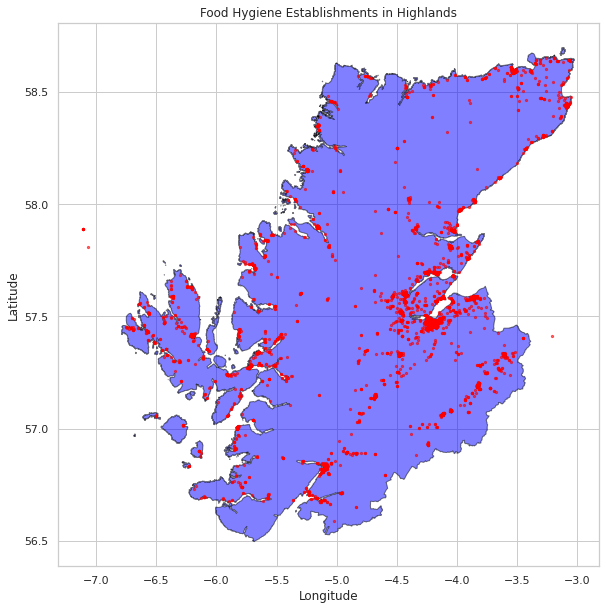

In [15]:
import geopandas as gpd

#Get dataframe
df_geo = pd.read_sql_query("""
SELECT BusinessName, BusinessType, RatingValue, PostCode, SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode, Longitude, Latitude 
FROM establishments
WHERE PartPostCode LIKE "KW%" OR PartPostCode LIKE "IV%" OR PartPostCode LIKE "PH%" OR PartPostCode LIKE "PA%";
""", conn)

#Load Scottish local authority boundaries
#Please look at the README file to find instructions on how to download the boundary shapefiles
la_gdf = gpd.read_file("/mnt/d/renfrewshire_business_insights/data/pub_las.shp") #local authority GeoDataFrame

print(la_gdf.columns.tolist()) #print all available columns in the GeoDataFrame
print("All available authority names: ") #Check all available authority names
print(la_gdf["local_auth"].unique())  # Optional: inspect names

#Filter for Highland
high_gdf = la_gdf[la_gdf["local_auth"] == "Highland"].copy()

#Filter out null coordinates from the hygiene dataframe
df_geo = df_geo[df_geo['Latitude'].notnull() & df_geo['Longitude'].notnull()]

#Convert DataFrame to GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo.Longitude.astype(float), df_geo.Latitude.astype(float)),
    crs="EPSG:4326"
)

#Ensure CRS matches
high_gdf = high_gdf.to_crs(epsg=4326)

#Plotting
fig, ax = plt.subplots(figsize=(10, 10))
high_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha = 0.5)
points_gdf.plot(ax=ax, markersize=5, alpha=0.6, color='red')
plt.title("Food Hygiene Establishments in Highlands")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

The highlighted area corresponds to the Highland Council Area

Before that, we can plot hygiene ratings onto this map as follows.

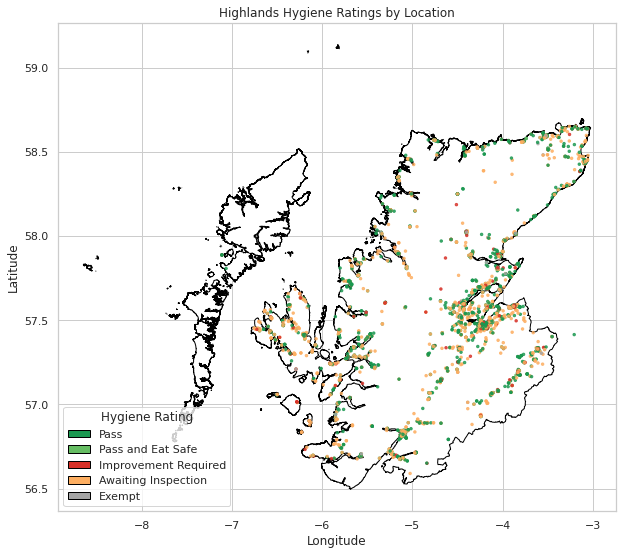

In [17]:
#Generate the local authority boundaries to a single GeoDataFrame
included_areas = ["Highland", "Na h-Eileanan an Iar"]
boundary_gdf = la_gdf[la_gdf["local_auth"].isin(included_areas)].copy() #boundary dataframe
boundary_gdf = boundary_gdf.to_crs(epsg=4326) #covnert to consitent CRS

# Map each string rating to a colour
rating_colors = {
    "Pass": "#1a9850",                # green
    "Pass and Eat Safe": "#66bd63",   # light green
    "Improvement Required": "#d73027",# red
    "Awaiting Inspection": "#fdae61", # orange
    "Exempt": "#a6a6a6"               # grey
}

#Create a legend for the plot
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for label, color in rating_colors.items()
]

# Map rating to colours by adding a colour column to the dataframe
points_gdf["color"] = points_gdf["RatingValue"].map(rating_colors)

# #Diagnostics
# print(points_gdf[["Longitude", "Latitude", "geometry"]].head())
# print(points_gdf.geom_type.unique())
# print(points_gdf.crs)              

#Plot
fig, ax = plt.subplots(figsize=(10, 10))
boundary_gdf.plot(ax=ax, color="white", edgecolor="black")
points_gdf.plot(ax=ax, markersize=6, color=points_gdf["color"], alpha=0.8)

plt.title("Highlands Hygiene Ratings by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(handles=legend_elements, title="Hygiene Rating", loc='lower left')
plt.show()


As the vast majority of hygiene ratings were pass, it is expected to see most of the data points be the same colour.

Using `contextily` we can create static map with geographic data to layer under the above plot.

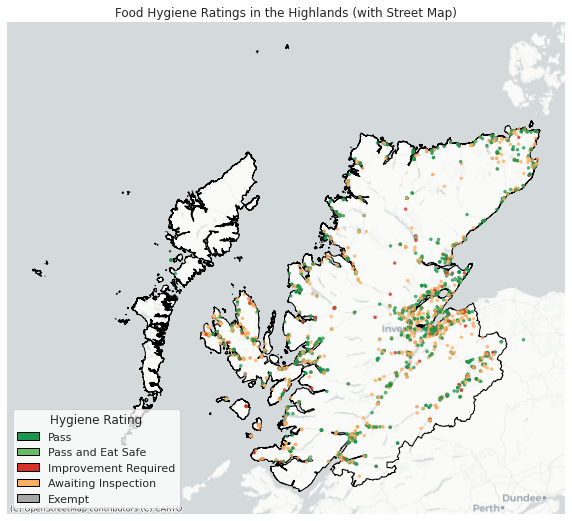

In [18]:
#Use contextily to plot street map underneath plots
import contextily as ctx

#Reproject both GeoDataFrames to EPSG:3857 (Web Mercator)
points_web = points_gdf.to_crs(epsg=3857)
boundary_web = boundary_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

#Plot boundary outline
boundary_web.plot(ax=ax, color='none', edgecolor='black')
points_web.plot(ax=ax, markersize=6, color=points_web['color'], alpha=0.7) #Plot hygiene points (coloured by rating, as before)

#Add basemap tiles
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) #OpenMap full colour
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) #grayscale overlay

plt.title("Food Hygiene Ratings in the Highlands (with Street Map)")
plt.axis("off")
plt.legend(handles=legend_elements, title="Hygiene Rating", loc='lower left')
plt.show()

## Interactive map using Folium and GeoPandas

In [24]:
print(points_web["color"])

#Generate the base map
#map_center = [points_web["Latitude"].astype(float).mean(), points_web["Longitude"].astype(float).mean()]
#m = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB Positron")

m = points_web.explore(
     column = "RatingValue",                
     tiles = None,
     tooltip = ["BusinessName", "PostCode", "RatingValue"],
     popup = False,
     cmap = "jet_r",
     legend_kwds = {"caption": "Markers Hygiene Rating"},
     name = "Markers" #name of the layer
)

#Add tile layer with customer layer name
folium.TileLayer(
    tiles="https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
    attr="© OpenStreetMap contributors & CartoDB",
    name="Light map",     #This name appears in the layer control
    control=True,
    show = True
).add_to(m)

#Dark Mode (CartoDB Dark Matter)
folium.TileLayer(
    tiles="https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png",
    name="Dark Map",
    attr="© OpenStreetMap & CartoDB",
    show = False,
).add_to(m)

#Satellite (Esri World Imagery)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    name="Satellite",
    attr="Tiles © Esri",
    show = False
).add_to(m)

#add a business density heatmap
heat_data = [[row["Latitude"], row["Longitude"]] for _, row in points_web.iterrows()]
heat = folium.FeatureGroup(name="Business density heatmap", show = True)
HeatMap(heat_data, min_opacity=0.4, radius=15).add_to(heat)
heat.add_to(m)

#Add a layer highlighting Improvement required
improve_df = points_web[points_web["RatingValue"] == "Improvement Required"] #find the points
improve_layer = folium.FeatureGroup(name = "Improvement Required (Red Markers)", show = False)
for _, row in improve_df.iterrows():
    tooltip_text = (
        f"<b>{row['BusinessName']}</b><br>"
        f"Hygiene Rating: {row['RatingValue']}<br>"
        f"Postcode: {row['PostCode']}"
    )
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        color="black",
        weight = 2,
        fill=True,
        fill_color="red",
        fill_opacity=0.9,
        tooltip=folium.Tooltip(tooltip_text)
    ).add_to(improve_layer)

improve_layer.add_to(m)

#Add improvement required heatmap
improve_heat_layer = folium.FeatureGroup(name="Improvement Required (Heatmap)", show = False)
heat_data = [[row["Latitude"], row["Longitude"]] for _, row in improve_df.iterrows()]
HeatMap(heat_data, min_opacity=0.4, radius=15, blur=10).add_to(improve_heat_layer)
improve_heat_layer.add_to(m)

#Add layer control toggle
folium.LayerControl(collapsed = False).add_to(m)

#add sources
m.get_root().html.add_child(folium.Element("""
    <div style="position: fixed; bottom: 5px; left: 5px; font-size: 11px; background-color: white; padding: 4px; border: 1px solid #ccc;">
        Source: <a href='https://ratings.food.gov.uk/open-data/en-GB' target='_blank'>FSA Hygiene Ratings</a>
    </div>
"""))


#Save
m.save("/mnt/d/renfrewshire_business_insights/docs/highland_hygiene_ratings.html")


0       #fdae61
1       #fdae61
2       #fdae61
4       #fdae61
5       #1a9850
         ...   
5373    #1a9850
5374    #fdae61
5375    #1a9850
5376    #fdae61
5377    #1a9850
Name: color, Length: 4695, dtype: object


### Outliers

Use the WHERE SQL command to find specific postcodes for outlier analysis.

In [23]:
outliers = pd.read_sql_query("""
SELECT BusinessName, BusinessType, PostCode, AddressLine1,
AddressLine2, AddressLine3, AddressLine4
FROM establishments
WHERE PostCode LIKE "G%" OR PostCode LIKE "A%";
""", conn)

outliers.head()

,BusinessName,BusinessType,PostCode,AddressLine1,AddressLine2,AddressLine3,AddressLine4
0,Angela Morrison,Distributors/Transporters,G83 8SB,Gargowan Lodge,South Avenue,Gartocharn,Alexandria
1,Bridge of Brown Teas Room,Other catering premises,AB37 9HR,Bridge Of Brown Tearoom,None,Tomintoul,Ballindalloch
2,FREDDO MUNDO,Mobile caterer,G51 2TB,None,60 Ibrox Terrace,Glasgow,None


Two of the results are mobile caterers which could explain the lack of a business address within the confines of Renfrewshire. 

## Tableau conversion

In [ ]:
#Convert points GeoDataFrame to csv
#points_web.drop(columns="geometry").to_csv("/mnt/d/renfrewshire_business_insights/data/establishments_clean.csv", index = False)

## Conclusions ##

“This analysis explored food hygiene trends in the Highlands using publicly available inspection data, geospatial mapping, and simulated Yelp enrichment. It demonstrates core data skills including SQL, Python, spatial joins, and visual communication.”

## Save and Close

In [ ]:
conn.close()